### Import

In [1]:
import os
import torch
import sys
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix

### Get the MNIST data - From the Demo

In [2]:
num_workers = 0
batch_size = 50
valid_size = 0.2
transform = transforms.ToTensor()
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

### Create Random Split Between the datasets

In [3]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

### Create Loaders

In [4]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size, 
                                           sampler = train_sampler, 
                                           num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                           sampler = valid_sampler, 
                                           num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = batch_size,
                                          num_workers = num_workers)

### Convert all data to a tensor for computing overall loss and accuracy

In [5]:
train_tensor = train_data.data
train_tensor = train_tensor.float()
train_tensor_labels = train_data.targets
test_tensor = test_data.data
test_tensor = test_tensor.float()
test_tensor_labels = test_data.targets

### Plot Some Data as a Sanity Check

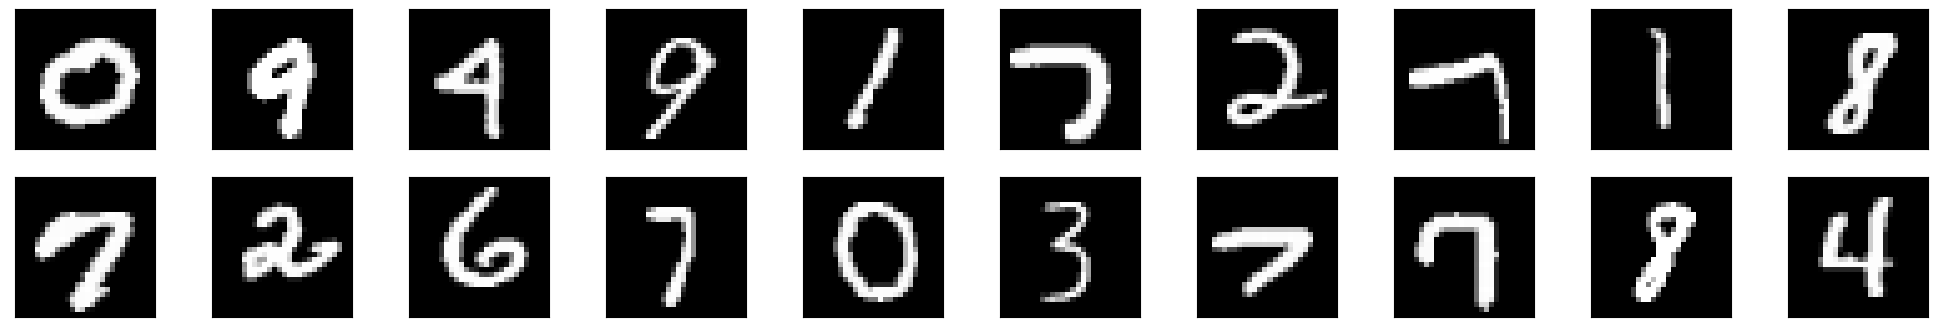

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

### Create Deep Belief Model

In [29]:
class DeepBeliefClassifier(nn.Module):

    def __init__(self,hidden_1,hidden_2,no_classes):
        super(DeepBeliefClassifier,self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,no_classes)
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x

### Parameters

In [30]:
learningRate = 0.01 
n_epochs = 100

### Instantiate Model

In [31]:
model = DeepBeliefClassifier(512,512,10)

### Optimizer parameters

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learningRate)

### Start Training

In [34]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []
for epoch in range(n_epochs):

    #Training
    model.train()
    for train_inputs,train_labels in train_loader:
        optimizer.zero_grad()
        train_output = model(train_inputs)
        train_loss = criterion(train_output,train_labels)
        train_loss.backward()
        optimizer.step()
    
    #Validation
    model.eval()
    for _inputs,val_labels in valid_loader:
        val_output = model(val_inputs)
        val_loss = criterion(val_output,val_labels)

        
    #Compute accuracy and loss after epoch
    train_output = model(train_tensor)
    train_loss = criterion(train_output,train_tensor_labels)
    train_loss_history.append(train_loss.item())
    _,train_pred = torch.max(train_output, 1)    
    train_accuracy = np.sum(train_pred.numpy() == train_tensor_labels.numpy()) / len(train_tensor_labels.numpy())
    train_accuracy_history.append(train_accuracy)
    
    #Compute accuracy and loss after epoch
    test_output = model(test_tensor)
    test_loss = criterion(test_output,test_tensor_labels)
    test_loss_history.append(test_loss.item())
    _,test_pred = torch.max(test_output,1)
    test_accuracy = np.sum(test_pred.numpy() == test_tensor_labels.numpy()) / len(test_tensor_labels.numpy())
    test_accuracy_history.append(test_accuracy)
    
    #Verbose
    if (epoch % 1 == 0):
        print('Epoch: {}, Training Loss: {:.6f}, Test Loss: {:.6f}'.format(epoch, train_loss,test_loss))
    
#Save the model
torch.save(model.state_dict(), 'model.pt')

Epoch: 0, Training Loss: 42.533752, Test Loss: 40.434502
Epoch: 1, Training Loss: 41.765484, Test Loss: 40.248192
Epoch: 2, Training Loss: 39.449326, Test Loss: 38.416882
Epoch: 3, Training Loss: 37.210674, Test Loss: 36.538780
Epoch: 4, Training Loss: 34.294804, Test Loss: 34.556389
Epoch: 5, Training Loss: 34.384289, Test Loss: 34.401073
Epoch: 6, Training Loss: 30.759727, Test Loss: 31.431244
Epoch: 7, Training Loss: 29.645716, Test Loss: 30.485659
Epoch: 8, Training Loss: 27.201706, Test Loss: 28.310127
Epoch: 9, Training Loss: 25.219931, Test Loss: 26.357325
Epoch: 10, Training Loss: 23.938145, Test Loss: 25.121246
Epoch: 11, Training Loss: 22.276363, Test Loss: 23.776646
Epoch: 12, Training Loss: 21.043394, Test Loss: 22.547028
Epoch: 13, Training Loss: 19.491949, Test Loss: 21.212257
Epoch: 14, Training Loss: 18.946720, Test Loss: 20.969522
Epoch: 15, Training Loss: 17.203140, Test Loss: 19.192278
Epoch: 16, Training Loss: 17.615633, Test Loss: 19.991896
Epoch: 17, Training Loss

### Plot Loss and accuracy

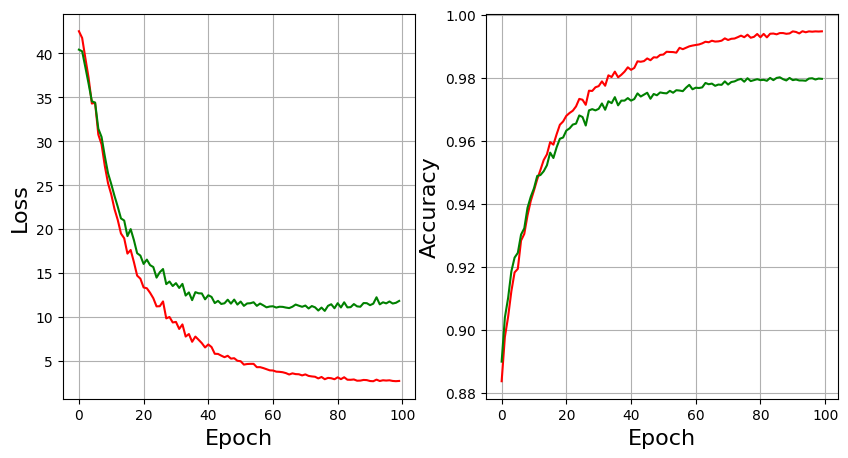

In [35]:
train_loss_history = np.array(train_loss_history)
test_loss_history = np.array(test_loss_history)
train_accuracy_history = np.array(train_accuracy_history)
test_accuracy_history = np.array(test_accuracy_history)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history,'r')
plt.plot(test_loss_history,'g')
plt.grid();
plt.xlabel('Epoch',fontsize=16);
plt.ylabel('Loss',fontsize=16);

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,'r')
plt.plot(test_accuracy_history,'g')
plt.grid();
plt.xlabel('Epoch',fontsize=16);
plt.ylabel('Accuracy',fontsize=16);

### Get Parameters and compare with actual coefficients

In [36]:
# for name,param in model.named_parameters():
#     if 'weight' in name:
#         w = param[0].detach().numpy()
#         print(name)
#         print(w)
#     if 'bias' in name:
#         b = param[0].detach().numpy()        
#         print(name)
#         print(b)

### Create Confusion Matrix

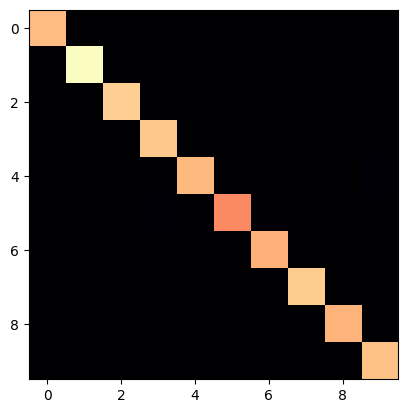

In [38]:
model.eval()
test_output = model(test_tensor)
_,test_pred = torch.max(test_output,1)
test_pred = test_pred.numpy()
C = confusion_matrix(test_tensor_labels, test_pred)
plt.imshow(C,cmap='magma')